## Marginalization.

This notebook documents efforts to make the likelihood function converge in an effort to estimate the diffusion coefficient through marginalization. If we find a way to make it converge, this notebook will be deleted and merged with the tutorial notebook.

In [1]:
%matplotlib inline

import Bayesian_Particle_Tracking
from Bayesian_Particle_Tracking import model
from Bayesian_Particle_Tracking.model import log_likelihood, log_posterior, log_prior, diffusion, displacement
from Bayesian_Particle_Tracking import io
from Bayesian_Particle_Tracking.prior import JeffreysPrior, UniformPrior
from Bayesian_Particle_Tracking.generate_data import generator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

/Users/alanzhou/anaconda3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


We'll start off by creating 4 separate data sets, each with the same parameters $\sigma_{m,i} = 10^{-8}$ and $D = 10^{-10}$, with the number 10, 100, 500, and 1000  points generated respectively.

In [12]:
test_data_10 = diffusion(generator(10,1e-8,1e-10,[0,0,0], parameter = "D"))
test_data_100 = diffusion(generator(100,1e-8,1e-10,[0,0,0], parameter = "D"))
test_data_500 = diffusion(generator(500,1e-8,1e-10,[0,0,0], parameter = "D"))
test_data_1000 = diffusion(generator(1000,1e-8,1e-10,[0,0,0], parameter = "D"))

This is a function that will allow us to guess the correct safety factor so that our likelihood function will converge.

In [13]:
def safe_likelihood_0(diffusion_object, max_value, log_lower_bound, log_upper_bound, iterations, safety_factor = 1, start_value = 0):
    D = np.logspace(log_lower_bound, log_upper_bound, iterations)
    for i in range(start_value, max_value):
        result = np.array(list(map(lambda d: likelihood(d, diffusion_object, 10**(-i/safety_factor)), D)))
        total = np.sum(result)
        print("max: %.3e min: %.3e total: %.3e" %(result.max(), result.min(), total))
        if total > 0 and total != np.inf:
            return D, result/total, i/safety_factor
        if total == 0:
            return_value_big = i/safety_factor
            return_value_small = (i-1)/safety_factor
            print("Increase Safety Factor. Good value of safety_scale/safety_factor is between %.4e and %.4e" %(return_value_small, return_value_big))
            break
    print("max_value.")

This function is a more dangerous version of the above function, as it won't really stop until the right saftey factor is found. We won't use this on the 1000 data point data set because the notebook crashes.

In [4]:
def safe_likelihood(diffusion_object, max_value, log_lower_bound, log_upper_bound, iterations, safety_factor = 1, start_value = 0, safety_constant = 0):
    D = np.logspace(log_lower_bound, log_upper_bound, iterations)
    for i in range(start_value, max_value):
        result = np.array(list(map(lambda d: likelihood(d, diffusion_object, 10**(-i/safety_factor - safety_constant)), D)))
        total = np.sum(result)
        if total > 0 and total != np.inf:
            print("max: %.3e min: %.3e total: %.3e" %(result.max(), result.min(), total))
            print("Exponent: %.4f" %(-i/safety_factor - safety_constant))
            return D, result/total, i/safety_factor - safety_constant
        if total == 0:
            return_value_big = i/safety_factor + safety_constant
            return_value_small = (i-1)/safety_factor + safety_constant
            print("Good value of (-i/safety_factor - safety_constant) is between %.4f and %.4f" %(return_value_small, return_value_big))
            return safe_likelihood(diffusion_object, max_value, log_lower_bound, log_upper_bound, iterations, safety_factor = safety_factor + 1, safety_constant = return_value_small)
    print("Did not find a safe value. Try increasing the number of iterations or changing the safety factor.")
    return None
    

We'll define our likelihood function here. 

In [5]:
def likelihood(theta, diffusion_object, safety_scale, unknown = 'D', known_variables = None):

    data = diffusion_object.data
    ndim = diffusion_object.dim
    sigma_m = diffusion_object.sigma_m

    #This code assumes the diffusion obeject gives absolute time instead of time displacements
    time = diffusion_object.time
    tau = time[1:len(time)] - time[0:len(time)-1]
    distance = displacement(data)

    if unknown == 'D':
        D = theta
    
    #sigma is the error on the displacement. This comes from the error propogation terms in the positional measurments, sigma1 and sigma2.
    sigma_1 = sigma_m[1:len(sigma_m)]
    sigma_2 = sigma_m[:len(sigma_m)-1]
    sigma = np.sqrt(sigma_1**2+sigma_2**2)

    diffusion_factor = np.sqrt(2*ndim*D*tau)

    result = (2*np.pi)**(-len(data)/2)*np.product(safety_scale/np.sqrt(sigma**2+diffusion_factor**2))*np.exp(np.sum(-((distance)**2)/(2*(diffusion_factor**2+sigma**2))))

    return result

max: 7.178e+34 min: 8.483e+30 total: 3.401e+37
Exponent: 0.0000
scale_10: 0.000e+00


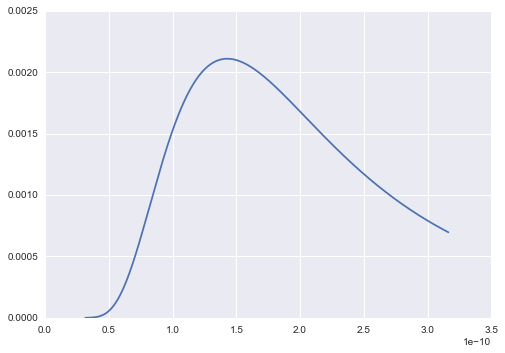

In [21]:
D_10, likelihood_10, scale_10 = safe_likelihood(test_data_10, 100, -10.5, -9.5, 1000, safety_factor = 1, start_value = 0)
print("scale_10: %.3e" %scale_10)
plt.plot(D_10, likelihood_10)

max: 3.478e+194 min: 6.885e+166 total: 5.385e+196
Exponent: -2.0000
scale_10: 2.000e+00


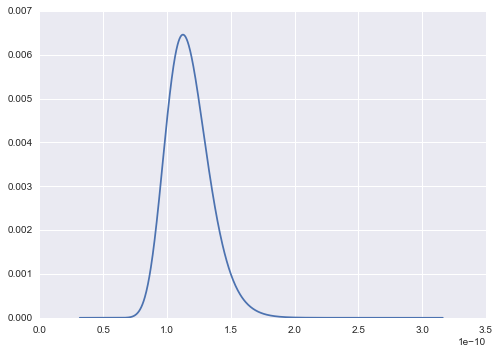

In [22]:
D_100, likelihood_100, scale_100 = safe_likelihood(test_data_100, 100, -10.5, -9.5, 1000, safety_factor = 1, start_value = 0)
print("scale_10: %.3e" %scale_100)
plt.plot(D_100, likelihood_100)

Good value of (-i/safety_factor - safety_constant) is between 4.0000 and 5.0000
max: 3.202e-247 min: 0.000e+00 total: 2.206e-245
Exponent: -4.5000
scale_10: -3.500e+00


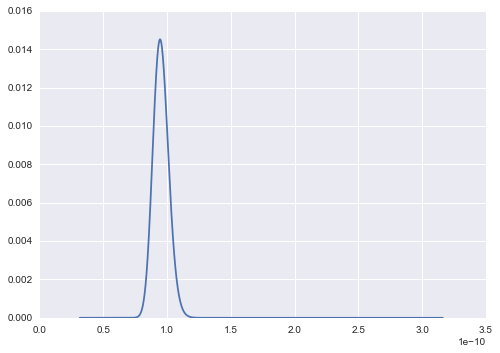

In [23]:
D_500, likelihood_500, scale_500 = safe_likelihood(test_data_500, 100, -10.5, -9.5, 1000, safety_factor = 1, start_value = 0)
print("scale_10: %.3e" %scale_500)
plt.plot(D_500, likelihood_500)

Up to now, there have been relatively few hitches, but once we get up to around 1000 data points, it becomes nearly impossible to find the right scaling factor.

In [24]:
D_1000, likelihood_1000, scale_1000 = safe_likelihood_0(test_data_500, 100, -10.5, -9.5, 100, safety_factor = 1, start_value = 0)
print("scale_10: %.3e" %scale_1000)
plt.plot(D_1000, likelihood_1000)

max: nan min: nan total: nan
max: nan min: nan total: nan
max: nan min: nan total: nan
max: nan min: nan total: nan
max: nan min: nan total: nan
max: 0.000e+00 min: 0.000e+00 total: 0.000e+00
Increase Safety Factor. Good value of safety_scale/safety_factor is between 4.0000e+00 and 5.0000e+00
max_value.


TypeError: 'NoneType' object is not iterable